# Imports


In [17]:
import numpy as np
import os
import matplotlib.pyplot as plt

# Access functions

In [18]:
def retrieve_time(path):
    """
    This function retrieves the timing of a certain measurement.

    Input:
     - path: inner path to the folder containing a result (consider to address a path/job.out)

    Output:
     - A float representing time or an error
    """
    f = open(path + "/job.out", "r")
    return float(f.readlines()[1][6:])

In [3]:
def retrieve_settings(path):
    """
    This function retrieves all the settings for a certain measurement.

    Input:
     - path: inner path to the folder containing a result (consider to address a path/job.out)

    Output: 
     - A numpy array of settings in format np.float64
    """
    options = path.split("/")
    settings = np.array([], dtype=np.float64)
    for set in options:
        if not str.isalpha(set.split("_")[-1]):
            settings = np.append(settings, np.float64(set.split("_")[-1]))
            
    return settings

# Dataset creation

In [4]:
# These indexes allow us to rapidly swap the number of parameter in consideration during generation.

sequential_idx = {"seq_length": 0, "patterns": 1, "mean_path_length": 2, "time_std": 3, "mean_time": 4}
pthreads_idx = {"threads": 0, "seq_length": 1, "patterns": 2, "mean_path_length": 3, "time_std": 4, "mean_time": 5}

In [5]:
def raw_dataset(path, dataset):
    """
    This function recursively explores the results folder and gathers data about the measurements.

    Input:
     - path: the path of the dataset
     - dataset: whatever numpy array of np.float64 with the same dimension as the measurement variables

     Output: 
      - The dataset as a numpy array of np.float64. The shape of the array is (measurements, variables),
        where the last variable is the timing of the measurement
    """
    new_dataset = np.copy(dataset)
    if not os.path.isdir(path) or os.listdir(path) == []:
        return dataset
    elif "job.out" in os.listdir(path):
        try:
            time = retrieve_time(path)
            settings = retrieve_settings(path)
            row = np.append(settings, np.float64(time)).reshape(1, -1)
            return np.append(new_dataset, row, axis=0)
        except:
            return new_dataset
    else:
        for dir in os.listdir(path):
            new_dataset = raw_dataset(path + "/" + dir, new_dataset)

    return new_dataset

In [ ]:
# Testing

sequential_times = raw_dataset("results/logs/sequential", np.zeros(shape=(1, len(sequential_idx)), dtype=np.float64))
np.set_printoptions(threshold=np.inf)
sequential_times[np.lexsort(np.transpose(sequential_times)[::-1])]

array([[0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00],
       [1.000000e+01, 1.000000e+01, 4.000000e+00, 1.000000e+00,
        6.332000e-03],
       [1.000000e+01, 1.000000e+01, 4.000000e+00, 2.000000e+00,
        6.938000e-03],
       [1.000000e+01, 1.000000e+01, 4.000000e+00, 3.000000e+00,
        9.601000e-03],
       [1.000000e+01, 1.000000e+01, 4.000000e+00, 4.000000e+00,
        8.701000e-03],
       [1.000000e+01, 1.000000e+01, 4.000000e+00, 5.000000e+00,
        6.261000e-03],
       [1.000000e+01, 1.000000e+01, 4.000000e+00, 6.000000e+00,
        9.928000e-03],
       [1.000000e+01, 1.000000e+01, 4.000000e+00, 7.000000e+00,
        6.237000e-03],
       [1.000000e+01, 1.000000e+01, 4.000000e+00, 8.000000e+00,
        9.618000e-03],
       [1.000000e+01, 1.000000e+01, 4.000000e+00, 9.000000e+00,
        9.079000e-03],
       [1.000000e+01, 1.000000e+01, 4.000000e+00, 1.000000e+01,
        6.603000e-03],
       [1.000000e+01, 1.500000e+01, 4.00000

## Aggregating on data to get mean and std

In [7]:
def aggregate_dataset(dataset):
    """
    This function takes in input a dataset of type (feature1, feature2... test_n, time), and returns a dataset of type (feature1, feature2... time_std, mean_time), with std and mean taken by aggregating on (feature1...feature(n-2)).

    Input:
     - dataset: a numpy array of np.float64 as in the description

    Output:
     - a numpy array of np.float64 as in the description
    """
    # Creating the dataset of settings
    dataset_unique = np.unique(dataset[:, :-2], axis=0)

    # Creating the dataset with mean and std
    aggregated = np.zeros((1, dataset.shape[1]), np.float64)
    for el in dataset_unique:
        # Creating the temporary array with a single setting
        tmp = np.zeros((1, dataset.shape[1]), np.float64)
        count = 0

        # Adding the real datapoints to such array
        for i in range(dataset.shape[0]):
            if np.array_equal(dataset[i, :-2], el):
                datapoint = np.reshape(dataset[i,], (1, -1))
                tmp = np.append(tmp, datapoint, axis=0)
                count += 1

        # Calculating mean and std by first removing the fake datapoint
        tmp = tmp[1:]
        tmp[:, -2] = np.std(tmp[:, -1])/np.sqrt(count)
        tmp[:, -1] = np.mean(tmp[:, -1])

        # Appending to the final dataset
        aggregated = np.append(aggregated, np.reshape(tmp[0], (1, -1)), axis=0)

    return aggregated[1:, ]

## Clean dataset creation


In [8]:
def create_dataset(path, idx, first_setting_column = 0):
    dataset = raw_dataset(path, np.zeros(shape=(1, len(idx)), dtype=np.float64))[1:, :]
    dataset[:, first_setting_column:-2] = np.power(2, dataset[:, first_setting_column:-2])
    dataset = dataset[np.lexsort(np.transpose(dataset)[::-1])]
    dataset = aggregate_dataset(dataset)
    return dataset

In [ ]:
# Testing

sequential = create_dataset("results/logs/sequential", sequential_idx)
pthreads = create_dataset("results/logs/pthreads", pthreads_idx, first_setting_column=1)
pthreads

array([[2.00000000e+00, 1.02400000e+03, 1.02400000e+03, 1.60000000e+01,
        2.19215082e-03, 8.17120000e-03],
       [2.00000000e+00, 1.02400000e+03, 3.27680000e+04, 1.60000000e+01,
        5.36081387e-03, 1.19254100e-01],
       [2.00000000e+00, 1.02400000e+03, 1.04857600e+06, 1.60000000e+01,
        1.71722792e-01, 3.92257310e+00],
       [4.00000000e+00, 1.02400000e+03, 1.02400000e+03, 1.60000000e+01,
        4.91863133e-03, 1.07327000e-02],
       [4.00000000e+00, 1.02400000e+03, 3.27680000e+04, 1.60000000e+01,
        3.17853273e-03, 6.06470000e-02],
       [4.00000000e+00, 1.02400000e+03, 1.04857600e+06, 1.60000000e+01,
        7.19837344e-02, 2.00457830e+00],
       [8.00000000e+00, 1.02400000e+03, 1.02400000e+03, 1.60000000e+01,
        3.34238700e-03, 6.79710000e-03],
       [8.00000000e+00, 1.02400000e+03, 3.27680000e+04, 1.60000000e+01,
        4.15426373e-03, 4.24185000e-02],
       [8.00000000e+00, 1.02400000e+03, 1.04857600e+06, 1.60000000e+01,
        5.00113334e-02, 

## Possible values of each variable

In [10]:
def domain(dataset, variable):
    """
    This function retrieves all the possible values of the dataset EXCLUDING the given variable, time_std and mean_time. 
    
    For example, if the variable is seq_length and the dataset is
    
    [seq_length | patterns | mean_path_length | time_std | mean_time] //this line is not actually part of the array
    
    [[10          10         4                   0.012    0.5]\n
    [15          10         4                   0.030     0.02]\n
    [20          15         4                   0.70      0.9]]\n

    the output will be

    [patterns | mean_path_length] //this line is not actually part of the array
    
    [[10        4]\n
    [15         4]]\n

    Input:
     - dataset: the output of create_dataset
     - variable: a value of an index dictionary (e.g. sequential_idx), whose column will
       be excluded when creating the set of unique values. Make sure the column actually matches
       the content of the given dataset

    Output:
     - a numpy array containing the described result 
    """
    return np.unique(np.delete(dataset, variable, axis=1)[:, :-2], axis=0)

In [11]:
# Testing

domain(sequential, sequential_idx["patterns"])

array([[1024.,   16.]])

# Comparing datasets


In [12]:
def comparison(dataset1, method1_idx, dataset2, method2_idx, variable):
    """
    This function returns an array that compares two datasets on a given variable x.
    It creates an array for each configuration of all the other variables that are not x, 
    effectively comparing the 2 methods as a result of varying a single variable.

    Input:
     - dataset1: an output of create_dataset
     - method1_idx: the dictionary of variables and indices associated to the first dataset
     - dataset2: an output of create_dataset
     - method2_idx: the dictionary of variables and indices associated to the second dataset
     - variable: the variable we are comparing on

    Output:
     - Two arrays with shape (configurations, range(variable)*measurements_per_configuration, len(methodj_idx) + 1),
       one per datset, where:
        - configurations is the output length of domain(datasetj, variable)
        - range(variable) is the number of total settings for that specific variable
        - measurements_per_configuration is the number of measurements per each experiment setting (including the variable itself)
        - len(methodj_idx) is the number of variables of a certain datset
        
        Mind that the last 2 dimensions are a numpy array.
    """
    new_dataset1 = []
    new_dataset2 = []
    for const in domain(dataset1, method1_idx[variable]):
        values = np.copy(dataset1)
        for i in range(dataset1.shape[1] - 3):
            if i >= method1_idx[variable]:
                values = values[(values[:, i+1] == const[i])]
            else:
                values = values[(values[:, i] == const[i])]
        new_dataset1.append(values)

    for const in domain(dataset2, method2_idx[variable]):
        values = np.copy(dataset2)
        for i in range(1, dataset2.shape[1] - 3):
            if i >= method2_idx[variable]:
                values = values[(values[:, i+1] == const[i])]
            else:
                values = values[(values[:, i] == const[i])]
        new_dataset2.append(values)
            
    return new_dataset1, new_dataset2

In [13]:
def sequential_vs_pthreads(variable):
    """
    A wrapper of the comparison function for sequential and pthreads data.
    """
    return comparison(sequential, sequential_idx, pthreads, pthreads_idx, variable)

In [14]:
# Testing

sequential_vs_pthreads("patterns")

([array([[1.02400000e+03, 1.02400000e+03, 1.60000000e+01, 4.74327288e-04,
          7.92980000e-03],
         [1.02400000e+03, 3.27680000e+04, 1.60000000e+01, 1.27881671e-02,
          2.32165600e-01],
         [1.02400000e+03, 1.04857600e+06, 1.60000000e+01, 3.33972034e-01,
          7.45121470e+00]])],
 [array([[2.00000000e+00, 1.02400000e+03, 1.02400000e+03, 1.60000000e+01,
          2.19215082e-03, 8.17120000e-03],
         [2.00000000e+00, 1.02400000e+03, 3.27680000e+04, 1.60000000e+01,
          5.36081387e-03, 1.19254100e-01],
         [2.00000000e+00, 1.02400000e+03, 1.04857600e+06, 1.60000000e+01,
          1.71722792e-01, 3.92257310e+00],
         [4.00000000e+00, 1.02400000e+03, 1.02400000e+03, 1.60000000e+01,
          4.91863133e-03, 1.07327000e-02],
         [4.00000000e+00, 1.02400000e+03, 3.27680000e+04, 1.60000000e+01,
          3.17853273e-03, 6.06470000e-02],
         [4.00000000e+00, 1.02400000e+03, 1.04857600e+06, 1.60000000e+01,
          7.19837344e-02, 2.0045783

# Comparison plotting

## Sequential vs PThreads

In [33]:
def plot_variable_sequential_pthreads(variable):
    """
    This function creates plots of pthreads and sequential corresponding to the arrays created in comparison.
    Check comparison's description for a thorough explanation.

    Input:
     - variable: the variable we are comparing on

    Output:
     - a multifaceted graph of time vs variable, where each facet is a fixed configuration
       of the other variables (again, check comparison's description)
    """
    # Grouping measurements by fixing all the other variables but the chosen one
    # Check sequntial_vs_pthreads for more info
    x_sequential, x_pthreads = sequential_vs_pthreads(variable)

    # Setting up the plots
    fig, axis = plt.subplots(len(x_sequential))

    # Fixing the interesting indexes
    seq_idx = sequential_idx[variable]
    pth_idx = pthreads_idx[variable]

    # Plotting each and every grouping
    for i, data in enumerate(zip(x_sequential, x_pthreads)):
        seq = data[0]
        pth = data[1]

        # Checking that groupings actually contain the same measurements
        if not np.array_equal(seq[0, :-2], pth[0, 1:-2]):
            print("Error! Groupings do not contain the same configurations")
            return
        
        # Checking that groupings have at least two measurements
        if (seq.shape[0] < 2 or pth.shape[0] < 2):
            print(f"Configuration {np.array2string(seq[0, :-2])} has been skipped due to lack of data")
            print(f"Sequential data has {seq.shape[0]} datapoints")
            print(f"PThreads data has {pth.shape[0]} datapoints")
            fig.delaxes(axis[i])
            continue

        # Ordering groupings by the interesting variable
        seq = seq[np.argsort(seq[:,seq_idx])]
        pth = pth[np.argsort(pth[:,pth_idx])]
          
        # Plotting the sequential datapoints for the chosen grouping
        axis[i].plot(seq[:, seq_idx], seq[:, -1], color='black', label = "Sequential (dashed expected results)")
        
        # Plotting a 95% ci 
        span = 1.96 * seq[:, -2]
        lower_ci = seq[:, -1] - span
        upper_ci = seq[:, -1] + span
        axis[i].fill_between(seq[:, seq_idx], lower_ci, upper_ci, alpha = 0.7, color = "black")
        
        # Plotting the expected parallel speedup for the chosen grouping
        for num_cores, colour in zip((sorted(set(pth[:, 0]))), ("red", "blue", "orange", "green")):
            exp_label = "Expected speedup for " + str(int(num_cores)) + " threads"
            def speedup(time):
                return time/num_cores
            exp_par_time = np.apply_along_axis(speedup, 0, seq[:, -1])

            axis[i].plot(seq[:, seq_idx], exp_par_time, color=colour, ls = "--")

        # Plotting the pthreads datapoints for the chosen grouping:
        # We need to group again on each thread number
        # THIS PART MUST BE CHANGED IF THE NUMBER OF VARIABLES CHANGES
        for j, colour in zip(sorted(set(pth[:, 0])), ("red", "blue", "orange", "green")):
            pth_group = pth[pth[:, 0] == j]
            pth_label = str(int(pth_group[0, 0])) + " threads"

            axis[i].plot(pth_group[:, pth_idx], pth_group[:, -1], color=colour, label = pth_label)
        
            # Plotting a 95% ci 
            span = 1.96 * pth_group[:, -2]
            lower_ci = pth_group[:, -1] - span
            upper_ci = pth_group[:, -1] + span

            axis[i].fill_between(pth_group[:, pth_idx], lower_ci, upper_ci, alpha = 0.7, color = colour)

            # Debugging std
            print(np.max(span))

        # Finishing the plot
        title = ""
        for k in sequential_idx.keys():
            if k != variable and k != "mean_time" and k != "time_std":
                title += k + "=" + str(seq[0, sequential_idx[k]]) + "\n"
        axis[i].set_title(title)
        axis[i].set_xlabel(variable)
        axis[i].set_ylabel('Time (s)')
        axis[i].set_yscale('log')
        axis[i].set_xscale('log', base = 2)
        axis[i].legend()
        axis[i].grid()
        
    fig.set_figheight(len(axis)*6)
    plt.legend()
    plt.tight_layout()
    plt.show()

TypeError: 'Axes' object is not subscriptable

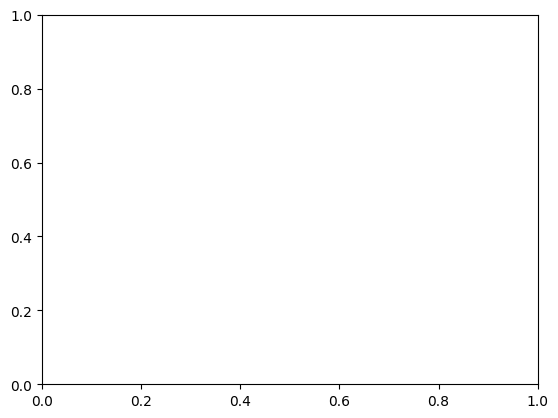

In [34]:
plot_variable_sequential_pthreads("patterns")

In [35]:
def plot_variable_sequential_pthreads_single(variable):
    """
    This function creates plots of pthreads and sequential corresponding to the arrays created in comparison.
    Check comparison's description for a thorough explanation.

    Input:
     - variable: the variable we are comparing on

    Output:
     - a multifaceted graph of time vs variable, where each facet is a fixed configuration
       of the other variables (again, check comparison's description)
    """
    # Grouping measurements by fixing all the other variables but the chosen one
    # Check sequntial_vs_pthreads for more info
    x_sequential, x_pthreads = sequential_vs_pthreads(variable)

    # Setting up the plots
    fig, axis = plt.subplots(len(x_sequential))

    # Fixing the interesting indexes
    seq_idx = sequential_idx[variable]
    pth_idx = pthreads_idx[variable]

    # Plotting each and every grouping
    for i, data in enumerate(zip(x_sequential, x_pthreads)):
        seq = data[0]
        pth = data[1]

        # Checking that groupings actually contain the same measurements
        if not np.array_equal(seq[0, :-2], pth[0, 1:-2]):
            print("Error! Groupings do not contain the same configurations")
            return
        
        # Checking that groupings have at least two measurements
        if (seq.shape[0] < 2 or pth.shape[0] < 2):
            print(f"Configuration {np.array2string(seq[0, :-2])} has been skipped due to lack of data")
            print(f"Sequential data has {seq.shape[0]} datapoints")
            print(f"PThreads data has {pth.shape[0]} datapoints")
            fig.delaxes(axis)
            continue

        # Ordering groupings by the interesting variable
        seq = seq[np.argsort(seq[:,seq_idx])]
        pth = pth[np.argsort(pth[:,pth_idx])]
          
        # Plotting the sequential datapoints for the chosen grouping
        axis.plot(seq[:, seq_idx], seq[:, -1], color='black', label = "Sequential (dashed expected results)")
        
        # Plotting a 95% ci 
        span = 1.96 * seq[:, -2]
        lower_ci = seq[:, -1] - span
        upper_ci = seq[:, -1] + span
        axis.fill_between(seq[:, seq_idx], lower_ci, upper_ci, alpha = 0.7, color = "black")
        
        # Plotting the expected parallel speedup for the chosen grouping
        for num_cores, colour in zip((sorted(set(pth[:, 0]))), ("red", "blue", "orange", "green")):
            exp_label = "Expected speedup for " + str(int(num_cores)) + " threads"
            def speedup(time):
                return time/num_cores
            exp_par_time = np.apply_along_axis(speedup, 0, seq[:, -1])

            axis.plot(seq[:, seq_idx], exp_par_time, color=colour, ls = "--")

        # Plotting the pthreads datapoints for the chosen grouping:
        # We need to group again on each thread number
        # THIS PART MUST BE CHANGED IF THE NUMBER OF VARIABLES CHANGES
        for j, colour in zip(sorted(set(pth[:, 0])), ("red", "blue", "orange", "green")):
            pth_group = pth[pth[:, 0] == j]
            pth_label = str(int(pth_group[0, 0])) + " threads"

            axis.plot(pth_group[:, pth_idx], pth_group[:, -1], color=colour, label = pth_label)
        
            # Plotting a 95% ci 
            span = 1.96 * pth_group[:, -2]
            lower_ci = pth_group[:, -1] - span
            upper_ci = pth_group[:, -1] + span

            axis.fill_between(pth_group[:, pth_idx], lower_ci, upper_ci, alpha = 0.7, color = colour)

            # Debugging std
            print(np.max(span))

        # Finishing the plot
        title = ""
        for k in sequential_idx.keys():
            if k != variable and k != "mean_time" and k != "time_std":
                title += k + "=" + str(seq[0, sequential_idx[k]]) + "\n"
        axis.set_title(title)
        axis.set_xlabel(variable)
        axis.set_ylabel('Time (s)')
        axis.set_yscale('log')
        axis.set_xscale('log', base = 2)
        axis.legend()
        axis.grid()
        
    fig.set_figheight(len(axis)*6)
    plt.legend()
    plt.tight_layout()
    plt.show()

0.33657667267025215
0.14108811943368316
0.09802221351649738
0.07697208968073983


TypeError: object of type 'Axes' has no len()

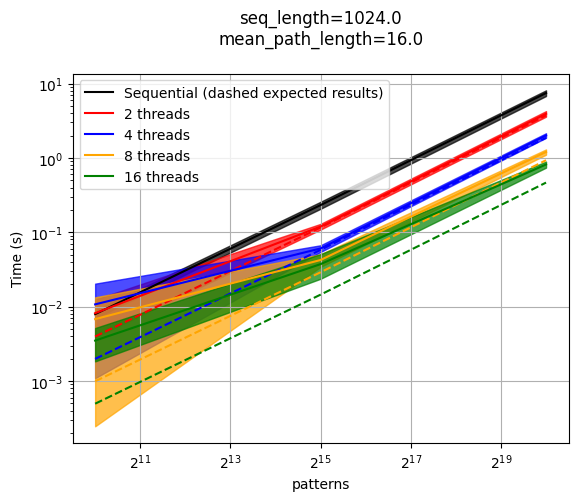

In [36]:
#plot_variable_sequential_pthreads_single("patterns")